# Analítica de datos
# Examen parcial 1
# 2020-01
# <font color='red'> Leider Stiven Calvo Gómez, A00012140 </font>

El dataset que deben analizar contiene los registros del histórico de las personas a las que se les ha otorgado un crédito financiero, indicando quienes pudieron pagarlo sin problemas y quienes no.

La idea es poder predecir, utilizando modelos de aprendizaje supervisado (KNN y Naïve Bayes) y las variables independientes disponibles qué aspirantes a un crédito tienen mas o menos riesgo de pagar.

Las variables de la hoja de datos son las siguientes:
- ID: El ID único del cliente en el banco. Variable numérica positiva. 
- PudoPagar: Indica si el cliente ha podido pagar el crédito sin problemas (1) o no (0). Variable categórica binaria.
- Estudiante: Indica si el cliente es estudiante (Si) o no lo es (No). Variable categórica binaria.
- Deuda: Indica la cantidad de dinero que aún adeuda el cliente correspondiente a préstamos. Valores numéricos positivos o en cero.
- Cuenta: Indica el dinero que tiene en la cuenta del banco. Valores numéricos. Estas cuentas no permiten tener saldo en rojo.

## Entendimiento de los datos, limpieza

El archivo "creditos_examen.csv" contiene el dataset que tienen que analizar.
Se recomienda abrirlo primero en un lector de archivos planos para entender preliminarmente su formato y así poderlo cargar adecuadamente con Python.

Teniendo en cuenta el tipo de problema en cuestión (clasificación o regresión), realice un análisis exploratorio de los datos estableciendo el baseline, verificando la calidad de los datos (tipos de las variables, valores inválidos, excepciones, valores faltantes, etc.), utilizando gráficos para poder entender las distribuciones de los datos e identificar posibles problemas.

#### Puntos a desarrollar

- <font color='red'>1. Limpieza de datos: Exploren los datos e identifiquen problemas e inconsistencias del dataset teniendo en cuenta el diccionario de datos y del contexto. Arreglen los problemas identificados (solo después de identificarlos todos), argumentando sus decisiones. (2.0)</font>
- <font color='red'>2. Obtengan el modelo de referencia (Baseline), interprételo y calcule su accuracy. (0.3)</font>

## Modelamiento con K-NN y Naïve Bayes

#### Puntos a desarrollar:

<font color='red'>Entrene modelos de clasificación siguiendo el siguiente protocolo:</font>
- <font color='red'>3. Haga un holdout estratificado 70% training - 30% test sobre el dataset solo incluyendo las variables numéricas. No olvide normalizar los datos correctamente (0.3)</font>
- <font color='red'>4. Sobre el training set siga un protocolo de 5 fold cross validation para buscar los mejores valores de los parámetros de un modelo K-NN, teniendo en cuenta el Kappa. Evaluar un modelo global, otro para estudiantes y otro para no estudiantes. Concluir (0.9)</font>
- <font color='red'>5. Sobre el training set siga un protocolo de 5 fold cross validation para buscar los mejores valores de los parámetros de un modelo NaïveBayes, tenga en cuenta utilizar las distribuciones adecuadas a los tipos de variables predictivas. Repetir el proceso de los tres modelos. (0.9) Si quisieramos incluir el efecto de la variable Estudiante en el modelo entrenado con las variables numéricas sin utilizar sklearn, que tenemos que hacer (0.2)</font>
- <font color='red'>6. Sobre el test set compare los dos modelos (K-NN y NB) y escoja el mejor según el Kappa (0.4)</font>

# Desarrollo de los puntos

In [68]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
import seaborn as sns
from sklearn import neighbors, datasets, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score, cross_validate #método para evaluar varios particionamientos de C-V
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, LeaveOneOut #Iteradores de C-V
from sklearn.naive_bayes import GaussianNB

# 1. Limpieza de datos

## Identificación de problemas de datos.

In [69]:
data = pd.read_csv('creditos_examen.csv', sep=";")
data.head()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
0,1,0,No,4436163,3647632
1,2,0,Si,1210613,4085902
2,3,0,No,3176714,5367746
3,4,0,No,3570449,2646253
4,5,0,No,3846350,3928279


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 5 columns):
ID            10002 non-null int64
PudoPagar     10002 non-null int64
Estudiante    9998 non-null object
Deuda         10002 non-null int64
Cuenta        10002 non-null int64
dtypes: int64(4), object(1)
memory usage: 390.8+ KB


In [71]:
data.describe(include="all")

,ID,PudoPagar,Estudiante,Deuda,Cuenta
count,10002.000000,10002.000000,9998,1.000200e+04,1.000200e+04
unique,NaN,NaN,4,NaN,NaN
top,NaN,NaN,No,NaN,NaN
freq,NaN,NaN,7050,NaN,NaN
mean,5000.379324,0.033293,NaN,3.036624e+06,1.545269e+07
std,2887.127481,0.179410,NaN,7.028235e+07,1.019546e+09
min,-3.000000,0.000000,NaN,-4.288864e+09,-2.247063e+07
25%,2500.250000,0.000000,NaN,1.823657e+06,2.408188e+06
50%,5000.500000,0.000000,NaN,3.209805e+06,4.118185e+06
75%,7500.750000,0.000000,NaN,4.281461e+06,5.833152e+06


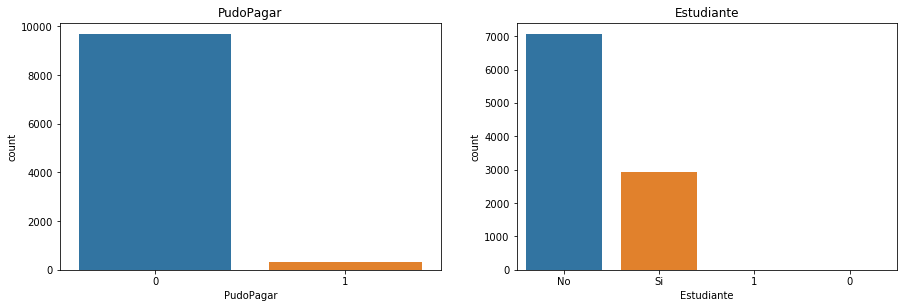

In [72]:
d = data.PudoPagar.astype('str')

fig = plt.figure(figsize=(15,10))
i=1

for var_num in data.columns[1:3]:
    ax = fig.add_subplot(2, 2, i) #Defino una tabla de 2 filas por 2 columnas, agrego el i-ésimo plot
    sns.countplot(x=var_num, data=data)
    plt.title(var_num)
    i+=1

**Los datos están super desbalanceados**

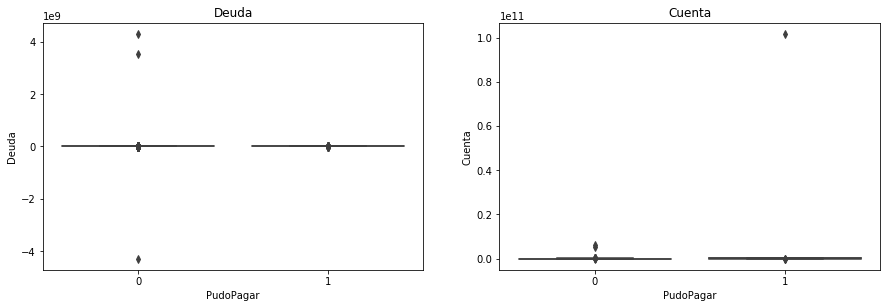

In [73]:
fig = plt.figure(figsize=(15,10))
i=1

for var_num in data.columns[3:5]:
    ax = fig.add_subplot(2, 2, i) #Defino una tabla de 2 filas por 2 columnas, agrego el i-ésimo plot
    sns.boxplot(x=d, y=var_num, data=data)
    plt.title(var_num)
    i+=1

- **"PudoPagar" y "Estudiante" son categoricas binarias pero se definen distinto sus valores**
- **"ID" aparece como numérico pero debería ser categorico, dado que es un identificador y no debería tratarse como un número**
- **"ID" tiene identificadores negativos**
- **"pudo pagar" se lee como numerica pero debería ser categórica según el diccionario de datos**
- **"Estudiante" tiene 4 missing values**
- **"Estudiante" tiene 4 valores únicos, no correspondientes a "si" o "no", sino "1" y "0"**
- **"Deuda" tiene valores negativos, contrario a lo que dice el diccionario.**
- **"Cuenta" tiene valores negativos, contrario a lo que dice el diccionario.**
- **"Deuda" tiene valores excepcionales**
- **"cuenta" tiene valores excepcionales**

## **Ahora voy a solucionar los problemas,desde los más básicos para que no me oculten información en los plots**

**Valores negativos de ID**

In [74]:
is_neg = data.loc[:, 'ID'] <4
df_neg = data.loc[is_neg]
df_neg.head()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
0,1,0,No,4436163,3647632
1,2,0,Si,1210613,4085902
2,3,0,No,3176714,5367746
1363,-3,0,No,4944040,3857756
6851,-1,0,No,3196574,358943


In [75]:
data.ID[1363] = np.absolute(data.ID[1363])
data.ID[6851] = np.absolute(data.ID[6851])
data.ID[6851]

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1

Los valores negativos de "ID" los considero registros actualizados de un mismo cliente que luego por ser duplicados, se elimininarán y guardarán el más reciente.

**Tipo de datos ID y PudoPagar**

In [76]:
data.PudoPagar = data.PudoPagar.astype('str')
data.ID = data.ID.astype('str')

data.Estudiante = data.Estudiante.replace("Si", "1")
data.Estudiante = data.Estudiante.replace("No", "0")
data.describe(include="all")

,ID,PudoPagar,Estudiante,Deuda,Cuenta
count,10002,10002,9998,1.000200e+04,1.000200e+04
unique,9996,2,2,NaN,NaN
top,500,0,0,NaN,NaN
freq,3,9669,7053,NaN,NaN
mean,NaN,NaN,NaN,3.036624e+06,1.545269e+07
std,NaN,NaN,NaN,7.028235e+07,1.019546e+09
min,NaN,NaN,NaN,-4.288864e+09,-2.247063e+07
25%,NaN,NaN,NaN,1.823657e+06,2.408188e+06
50%,NaN,NaN,NaN,3.209805e+06,4.118185e+06
75%,NaN,NaN,NaN,4.281461e+06,5.833152e+06


- Los tipos de dato de ID y Pudo pagar se cambiaron a str para poder ser tratados como categoricos
- PudoPagar y Estudiante se trabajan mejor si ambos están en los mismos valores binarios ("Si" -"No") ó ("1" - "0"), por eso debía escoger uno, asi que tomé ("1" - "0") dado que los valores atípicos de estudiante corresponde a esta escala.

**Registros duplicados**

In [77]:
a = data.duplicated()
#a = pd.DataFrame({'a':a}) 
a = a.replace(True, 1)
a = a.replace(False, 0)
a.sum()
#a.a.unique()

2.0

In [78]:
data = data.drop_duplicates(keep='last') #duplicados con todas las columnas
data = data.drop_duplicates(data.columns[0], keep='last') #registros duplicados con base en el ID
data.describe(include="all")

,ID,PudoPagar,Estudiante,Deuda,Cuenta
count,9996,9996,9992,9.996000e+03,9.996000e+03
unique,9996,2,2,NaN,NaN
top,3477,0,0,NaN,NaN
freq,1,9663,7049,NaN,NaN
mean,NaN,NaN,NaN,3.036512e+06,1.545945e+07
std,NaN,NaN,NaN,7.030344e+07,1.019852e+09
min,NaN,NaN,NaN,-4.288864e+09,-2.247063e+07
25%,NaN,NaN,NaN,1.823537e+06,2.407952e+06
50%,NaN,NaN,NaN,3.209805e+06,4.118185e+06
75%,NaN,NaN,NaN,4.281578e+06,5.833304e+06


In [79]:
del data['ID']
data.head()

,PudoPagar,Estudiante,Deuda,Cuenta
1,0,1,1210613,4085902
3,0,0,3570449,2646253
4,0,0,3846350,3928279
5,0,1,749156,4597943
6,0,0,2490523,4127567


Dado que ID tenía valores negativos , e incluso **registros repetidos**, como se nota en la cantidad de valores unicos del describe anterior y en la verficación de duplicados, opté por eliminar los registros duplicados (guardando los más actuales) y esta columna, ya que solo es un identificador ordenado escalar.

**Valores Nulos**

In [80]:
data = data.dropna()
data.describe(include="all")

,PudoPagar,Estudiante,Deuda,Cuenta
count,9992,9992,9.992000e+03,9.992000e+03
unique,2,2,NaN,NaN
top,0,0,NaN,NaN
freq,9659,7049,NaN,NaN
mean,NaN,NaN,3.036451e+06,1.546488e+07
std,NaN,NaN,7.031751e+07,1.020056e+09
min,NaN,NaN,-4.288864e+09,-2.247063e+07
25%,NaN,NaN,1.823380e+06,2.409126e+06
50%,NaN,NaN,3.209805e+06,4.118502e+06
75%,NaN,NaN,4.281987e+06,5.833682e+06


Los missing values de estudiante son tan pocos que es mas riesgoso tratar de predecir su valor, que no tenerlos en cuenta las evaluaciones, por lo tanto eliminaré dichos registros.

## **valores excepcionales**

In [81]:
for x in [0,0,0]:
    id = data[['Cuenta']].idxmax()
    print(id.Cuenta)
    data = data.drop([id.Cuenta],axis=0)

997
4246
2996


In [82]:
for x in [0,0]:
    id2 = data[['Deuda']].idxmax()
    print(id2.Deuda)
    data = data.drop([id2.Deuda],axis=0)

2499
2598


In [83]:
data = data.drop([data[['Deuda']].idxmin().Deuda],axis=0)
data = data.drop([data[['Cuenta']].idxmin().Cuenta],axis=0)
print(data.Cuenta.max())
print(data.Deuda.max())

13271613
7355423


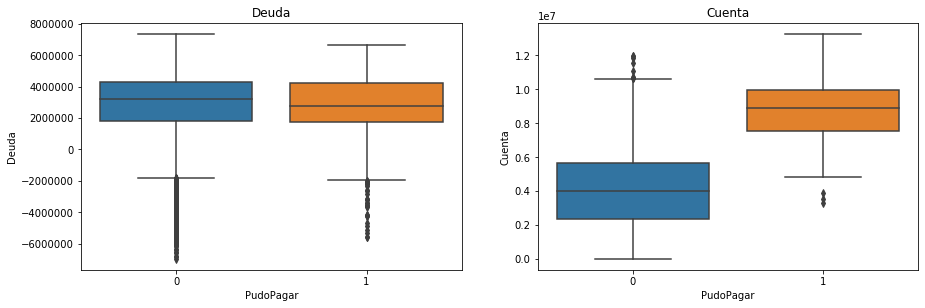

In [84]:
fig = plt.figure(figsize=(15,10))
i=1

for var_num in data.columns[2:4]:
    ax = fig.add_subplot(2, 2, i) #Defino una tabla de 2 filas por 2 columnas, agrego el i-ésimo plot
    sns.boxplot(x=data.PudoPagar, y=var_num, data=data)
    plt.title(var_num)
    i+=1

Se eliminan 3 valores excepcionales de la columna Cuenta y 2 deDeuda, dado que están demasiado lejos de los límites

## **Valores negativos en Deuda y Cuenta**

In [85]:
data.describe(include='all')

,PudoPagar,Estudiante,Deuda,Cuenta
count,9985,9985,9.985000e+03,9.985000e+03
unique,2,2,NaN,NaN
top,0,0,NaN,NaN
freq,9653,7042,NaN,NaN
mean,NaN,NaN,2.681678e+06,4.176570e+06
std,NaN,NaN,2.411874e+06,2.418012e+06
min,NaN,NaN,-6.954195e+06,0.000000e+00
25%,NaN,NaN,1.823183e+06,2.408889e+06
50%,NaN,NaN,3.206815e+06,4.118049e+06
75%,NaN,NaN,4.280070e+06,5.831066e+06


In [86]:
is_neg = data.loc[:, 'Deuda'] < 0
df_neg = data.loc[is_neg]
df_neg.head()

,PudoPagar,Estudiante,Deuda,Cuenta
1500,0,0,-6954195,632793
1501,0,0,-2424394,1936181
1502,1,1,-1177023,11664391
1503,0,0,-2441113,6797192
1504,0,0,-5836039,2346659


In [87]:
print( "media: ")
print( data.Deuda.mean() )
print( "desviación: " )
print( data.Deuda.std() )

media: 
2681678.137205809
desviación: 
2411873.530838004


In [88]:
data.Deuda = data.Deuda.abs()
data.Deuda[1500]

6954195

Asumí dejar su valor absoluto, sin grandes implicaciones debido a la poca cantidad de datos y debido a que los valores absolutos de las cuentas negativas están a menos de 1 desviacion estandar de la media. En cuanto a la variable Cuenta, no tiene ya valores negativos

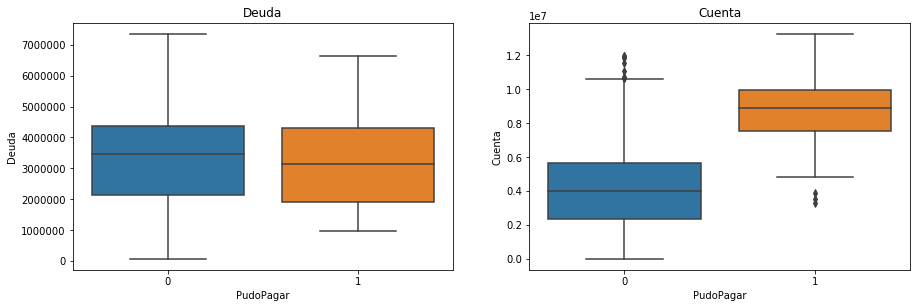

In [89]:
fig = plt.figure(figsize=(15,10))
i=1

for var_num in data.columns[2:4]:
    ax = fig.add_subplot(2, 2, i) #Defino una tabla de 2 filas por 2 columnas, agrego el i-ésimo plot
    sns.boxplot(x=data.PudoPagar, y=var_num, data=data)
    plt.title(var_num)
    i+=1

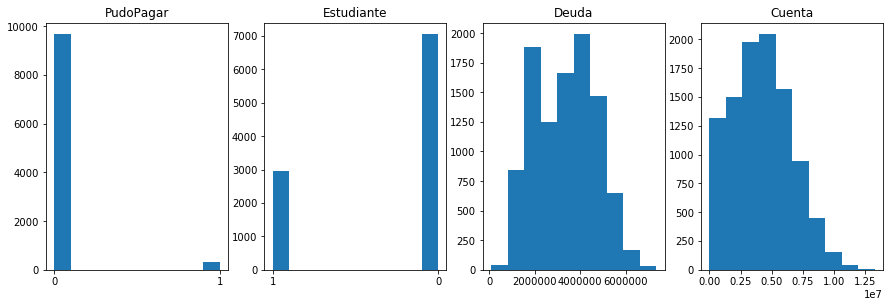

In [90]:
fig = plt.figure(figsize=(15,10))
i=1

for var_num in data.columns[:]:
    ax = fig.add_subplot(2, 4, i) #Defino una tabla de 2 filas por 2 columnas, agrego el i-ésimo plot
    plt.hist(data[var_num])
    plt.title(var_num)
    #plt.show()
    i+=1

Tenemos que el dataset después de limpieza cuenta con  **9985** registros.

# 2. Modelo de referencia (Baseline)

El Base line para este caso consistirá en predecir siempre que **no se podrá pagar** el credito, dado que es la clase mayoritaria.

In [91]:
dat = data.loc[:, 'PudoPagar'] == '0'
df_n = data.loc[dat]
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9653 entries, 1 to 10001
Data columns (total 4 columns):
PudoPagar     9653 non-null object
Estudiante    9653 non-null object
Deuda         9653 non-null int64
Cuenta        9653 non-null int64
dtypes: int64(2), object(2)
memory usage: 377.1+ KB


In [92]:
print("Exactitud: ", metrics.accuracy_score(['0']*9653 + ['1']*332, ['0']*9985))

Exactitud:  0.9667501251877817


Luego de ver que el base tiene un accuracy tan alto, se hace necesario un modelo que sea mucho más exacto, que le pegue a mas del 97% de las respuestas para que valga la pena su creación. **Esto se debe a que los datos están extremamente desbalanceados**

# 3. Holdout sobre el dataset

**Normalizar los datos**
El punto dice: "solo las variables numericas", pero si interpretamos que estudiante no hace parte de ellas, perderiamos dicha variable, útil en los próximos puntos

In [93]:
data["Deuda"] = data["Deuda"] / data["Deuda"].max()
data["Cuenta"] = data["Cuenta"] / data["Cuenta"].max()
data.head(5)

,PudoPagar,Estudiante,Deuda,Cuenta
1,0,1,0.164588,0.307868
3,0,0,0.485417,0.199392
4,0,0,0.522927,0.295991
5,0,1,0.101851,0.346449
6,0,0,0.338597,0.311007


In [94]:
x = pd.DataFrame({"Estudiante":data.Estudiante, "Deuda":data.Deuda, "Cuenta":data.Cuenta})
X_train, X_test, y_train, y_test = train_test_split(x, data["PudoPagar"], test_size=0.3, random_state=12345, stratify=data["PudoPagar"])

# 4. KNN

Se intentarán varios K predefinidos, y cada uno de ellos, se evalua con un 5 fold cross validation.

#### **Global**

In [95]:
#k_vec= np.arange(1,31,2)
k_vec= [8,9,10,11,12,13,14,15]
k_vec

[8, 9, 10, 11, 12, 13, 14, 15]

In [96]:
for k in k_vec:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    kappa_scorer = metrics.make_scorer(metrics.cohen_kappa_score)
    kp = cross_val_score(knn, X_train, y_train, cv=5, scoring=kappa_scorer)
    #kp = metrics.cohen_kappa_score(y_train, y_pred)
    print(k)
    print(kp)
    print("kapas: %0.2f (+/- %0.2f)" % (kp.mean(), kp.std() * 2))
    print("---------")

8
[0.37553482 0.47410408 0.41959644 0.35678282 0.33136567]
kapas: 0.39 (+/- 0.10)
---------
9
[0.41567121 0.50879287 0.56474065 0.40207295 0.35685011]
kapas: 0.45 (+/- 0.15)
---------
10
[0.36926512 0.51649759 0.54064088 0.32292929 0.33136567]
kapas: 0.42 (+/- 0.19)
---------
11
[0.39278871 0.50879287 0.56474065 0.40207295 0.38159846]
kapas: 0.45 (+/- 0.15)
---------
12
[0.32591912 0.51649759 0.54064088 0.3501318  0.3632054 ]
kapas: 0.42 (+/- 0.18)
---------
13
[0.37553482 0.51649759 0.58185309 0.36975257 0.38822327]
kapas: 0.45 (+/- 0.17)
---------
14
[0.35727172 0.50332052 0.51916706 0.32925013 0.3108689 ]
kapas: 0.40 (+/- 0.18)
---------
15
[0.37553482 0.51649759 0.54064088 0.37650043 0.35685011]
kapas: 0.43 (+/- 0.16)
---------


**9** es el valor de K que más aciertos tiene, entre lo que no es chiripa.
Se evaluo primero a una escala mas grande, y luego sobre estos valores más precisos. Y entre 9, 11 y 13 se escoge elimina 11 porque su intervalo de confianza es menos preciso. Se escoge nueve porque es equivalente a 11.

#### **Estudiantes**

In [97]:
#k_vec= np.arange(1,31,2)
k_vec= [10,11,12]
k_vec

[10, 11, 12]

In [98]:
data_est = data.loc[data['Estudiante'] == '1' ] 
x = pd.DataFrame({"Deuda":data_est.Deuda, "Cuenta":data_est.Cuenta})
X_train, X_test, y_train, y_test = train_test_split(x, data_est["PudoPagar"], test_size=0.3, random_state=12345, stratify=data_est["PudoPagar"])

In [99]:
for k in k_vec:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    kappa_scorer = metrics.make_scorer(metrics.cohen_kappa_score)
    kp = cross_val_score(knn, X_train, y_train, cv=5, scoring=kappa_scorer)
    #kp = metrics.cohen_kappa_score(y_train, y_pred)
    print(k)
    print(kp)
    print("kapas: %0.2f (+/- %0.2f)" % (kp.mean(), kp.std() * 2))
    print("---------")

10
[0.35152859 0.44735077 0.42777778 0.44666155 0.50330018]
kapas: 0.44 (+/- 0.10)
---------
11
[0.41021064 0.43075423 0.4650277  0.48389406 0.55703251]
kapas: 0.47 (+/- 0.10)
---------
12
[0.35152859 0.39369806 0.318445   0.4669586  0.52485549]
kapas: 0.41 (+/- 0.15)
---------


**11** es el valor de K que más aciertos tiene, entre lo que no es chiripa.
Se evaluo primero a una escala mas grande, y luego sobre estos valores más cercanos a 11 no evaluados. Se escoge 11 que nos brinda un kappa mas alto.

#### **No Estudiantes**

In [100]:
#k_vec= np.arange(1,31,2)
k_vec= [6,7,8]
k_vec

[6, 7, 8]

In [101]:
data_no_est = data.loc[data['Estudiante'] == '0' ] 
x = pd.DataFrame({"Deuda":data_no_est.Deuda, "Cuenta":data_no_est.Cuenta})
X_train, X_test, y_train, y_test = train_test_split(x, data_no_est["PudoPagar"], test_size=0.3, random_state=12345, stratify=data_no_est["PudoPagar"])

In [102]:
for k in k_vec:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    kappa_scorer = metrics.make_scorer(metrics.cohen_kappa_score)
    kp = cross_val_score(knn, X_train, y_train, cv=5, scoring=kappa_scorer)
    #kp = metrics.cohen_kappa_score(y_train, y_pred)
    print(k)
    print(kp)
    print("kapas: %0.2f (+/- %0.2f)" % (kp.mean(), kp.std() * 2))
    print("---------")

6
[0.29710126 0.40725244 0.16298812 0.30539734 0.34852774]
kapas: 0.30 (+/- 0.16)
---------
7
[0.4433949  0.44338336 0.18684604 0.46607204 0.38958893]
kapas: 0.39 (+/- 0.21)
---------
8
[0.30613238 0.40725244 0.15702479 0.38958893 0.40064552]
kapas: 0.33 (+/- 0.19)
---------


**7** es el valor de K que más aciertos tiene, entre lo que no es chiripa. Se evaluo primero a una escala mas grande, y luego sobre estos valores más cercanos a 7 no evaluados. Se escoge 7, que nos brinda un kappa mas alto.

### Conclución
Es interesante notar, como el parametro del Knn global **(9)**, es el promedio exacto de los parametros de los knn hijos **(7 , 11)**. Así mismo y aunque el Kappa de los knn hijos _(estudiante **39** y no estudiante **47**)_ no es exactamente el promedio del global, si se situa en el medio de ese intervalo **(45)**.
Por lo tanto, no diferencia significativa en crear modelos diferentes para cada tipo de usuario, a usar un modelo global.

# 5. Naive Bayes

En la documentación a diferencia de otras distribuciones, el Naive Bayes gaussiano se utiliza para variables cuantitativas continuas, en las que se asume una distribución normal. Por ello es la mejor opción para las variables dependientes Deuda y Cuenta. Así mismo, la documentacion de sklearn diferencia este modelo por la carencia de un alpha en sus parametros _**(sklearn.naive_bayes.GaussianNB(priors=None, var_smoothing=1e-09))**_. Por lo cual se debe decidir el mejor priors, y para mi el mejor, es el **Unset**, dado que garantiza el ajuste de las mismas de acuerdo a la data. Por otro lado, el **var_smoothing** nos va a permitir la variación del calculo respecto al suavizador de laplace 

In [103]:
x = pd.DataFrame({"Deuda":data.Deuda, "Cuenta":data.Cuenta})
X_train, X_test, y_train, y_test = train_test_split(x, data["PudoPagar"], test_size=0.3, random_state=12345, stratify=data["PudoPagar"])

In [104]:
#smoothing_nai= [0.1, 0.09, 0.08, 0.07, 0.05, 0.01, 0.005, 0.001, 0.0001]
smoothing_nai= [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001]
for smoot in smoothing_nai:
    modelo = GaussianNB(var_smoothing = smoot)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_train)
    kappa_scorer = metrics.make_scorer(metrics.cohen_kappa_score)
    kp = cross_val_score(modelo, X_train, y_train, cv=5, scoring=kappa_scorer)
    print(kp)
    print("kapas: %0.2f (+/- %0.2f)" % (kp.mean(), kp.std() * 2))
    print(smoot)

[0.32348461 0.44378672 0.36364756 0.33577738 0.22605784]
kapas: 0.34 (+/- 0.14)
0.05
[0.31734168 0.46691997 0.44343861 0.38345838 0.29410378]
kapas: 0.38 (+/- 0.14)
0.01
[0.34417776 0.4894051  0.46660194 0.38345838 0.29410378]
kapas: 0.40 (+/- 0.15)
0.005
[0.37020535 0.4894051  0.46660194 0.37650043 0.29410378]
kapas: 0.40 (+/- 0.14)
0.001
[0.37020535 0.4894051  0.46660194 0.37650043 0.29410378]
kapas: 0.40 (+/- 0.14)
0.0005
[0.37020535 0.4894051  0.46660194 0.37650043 0.29410378]
kapas: 0.40 (+/- 0.14)
0.0001
[0.37020535 0.4894051  0.46660194 0.37650043 0.29410378]
kapas: 0.40 (+/- 0.14)
1e-05


A partir de **0.001** los valores inferiores de SMOOT no varian mucho **(40%) de kappa**, por lo cual se tomará dicho valor como el mejor parametro para el naive bayes.

#### **Estudiantes**

In [105]:
x = pd.DataFrame({"Deuda":data_est.Deuda, "Cuenta":data_est.Cuenta})
X_train, X_test, y_train, y_test = train_test_split(x, data_est["PudoPagar"], test_size=0.3, random_state=12345, stratify=data_est["PudoPagar"])

In [106]:
#smoothing_nai= [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001]
smoothing_nai= [0.04, 0.03, 0.02, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004]
kappa_vec = []
for smoot in smoothing_nai:
    modelo = GaussianNB(var_smoothing = smoot)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_train)
    kappa_scorer = metrics.make_scorer(metrics.cohen_kappa_score)
    kp = cross_val_score(modelo, X_train, y_train, cv=5, scoring=kappa_scorer)
    kappa_vec.append(kp.mean())
    print(kp)
    print("kapas: %0.2f (+/- %0.2f)" % (kp.mean(), kp.std() * 2))
    print(smoot)

[0.38498958 0.51643192 0.0838015  0.33519793 0.44409378]
kapas: 0.35 (+/- 0.30)
0.04
[0.3676555  0.51643192 0.0838015  0.33519793 0.44409378]
kapas: 0.35 (+/- 0.29)
0.03
[0.3676555  0.51643192 0.0838015  0.33519793 0.44409378]
kapas: 0.35 (+/- 0.29)
0.02
[0.35152859 0.51643192 0.0838015  0.33519793 0.5111904 ]
kapas: 0.36 (+/- 0.32)
0.01
[0.35152859 0.51643192 0.0838015  0.33519793 0.5111904 ]
kapas: 0.36 (+/- 0.32)
0.009
[0.35152859 0.51643192 0.0838015  0.33519793 0.5111904 ]
kapas: 0.36 (+/- 0.32)
0.008
[0.35152859 0.51643192 0.0838015  0.33519793 0.5111904 ]
kapas: 0.36 (+/- 0.32)
0.007
[0.35152859 0.51643192 0.0838015  0.33519793 0.5111904 ]
kapas: 0.36 (+/- 0.32)
0.006
[0.35152859 0.51643192 0.0838015  0.33519793 0.48763765]
kapas: 0.35 (+/- 0.31)
0.005
[0.35152859 0.51643192 0.0838015  0.33519793 0.48763765]
kapas: 0.35 (+/- 0.31)
0.004


Text(0.5, 1.0, 'kappa vs smoot')

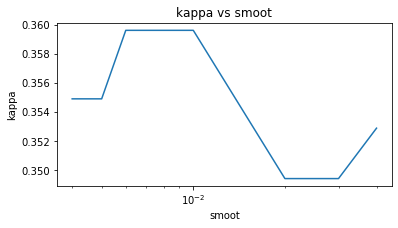

In [107]:
plt.figure(figsize=(6,3))
plt.plot(smoothing_nai, kappa_vec)
ax = plt.gca()
plt.xscale('log')
plt.xlabel('smoot')
plt.ylabel('kappa')
plt.title('kappa vs smoot')

A partir de **0.01** y hasta **0.008** los valores **kappa (36%)** se mantienen, pero a sus lados de nuevo caen, dibujando una curva, por lo cual se considera optimo cualquier valor en ese rango, que corresponde al pico de curva.

#### **No Estudiantes**

In [108]:
x = pd.DataFrame({"Deuda":data_no_est.Deuda, "Cuenta":data_no_est.Cuenta})
X_train, X_test, y_train, y_test = train_test_split(x, data_no_est["PudoPagar"], test_size=0.3, random_state=12345, stratify=data_no_est["PudoPagar"])

In [109]:
#smoothing_nai= [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001]
for smoot in smoothing_nai:
    modelo = GaussianNB(var_smoothing = smoot)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_train)
    kappa_scorer = metrics.make_scorer(metrics.cohen_kappa_score)
    kp = cross_val_score(modelo, X_train, y_train, cv=5, scoring=kappa_scorer)
    print(kp)
    print("kapas: %0.2f (+/- %0.2f)" % (kp.mean(), kp.std() * 2))
    print(smoot)

[0.26943005 0.22862129 0.17594255 0.23584174 0.33529912]
kapas: 0.25 (+/- 0.11)
0.04
[0.26943005 0.22071307 0.16928447 0.28696387 0.33529912]
kapas: 0.26 (+/- 0.11)
0.03
[0.26943005 0.26942149 0.16928447 0.33529912 0.33529912]
kapas: 0.28 (+/- 0.12)
0.02
[0.26943005 0.26942149 0.16928447 0.33529912 0.33529912]
kapas: 0.28 (+/- 0.12)
0.01
[0.26943005 0.26942149 0.16928447 0.33529912 0.33529912]
kapas: 0.28 (+/- 0.12)
0.009
[0.26943005 0.26942149 0.16928447 0.33529912 0.33529912]
kapas: 0.28 (+/- 0.12)
0.008
[0.26943005 0.26942149 0.16928447 0.33529912 0.33529912]
kapas: 0.28 (+/- 0.12)
0.007
[0.26943005 0.31561997 0.16928447 0.33529912 0.33529912]
kapas: 0.28 (+/- 0.13)
0.006
[0.26943005 0.35949765 0.16928447 0.33529912 0.33529912]
kapas: 0.29 (+/- 0.14)
0.005
[0.26943005 0.35949765 0.16928447 0.33529912 0.33529912]
kapas: 0.29 (+/- 0.14)
0.004


A partir de **0.005** los valores **kappa (29%)** se mantienen sin variación a pesar del tamaño de los saltos. Por ello cualquier valor **de los evaluados** a partir de ahi es valido.

### Conclución
A diferencia del modelo anterior, tenemos mejores aciertos con un modelo general, que con unos especificos para estudiantes o no estudiantes. Además, al igual que en los modelos Knn, estos modelos siguen siendo mejores que el baseline, por lo cual todos son provechosos. sin embargo, son preferibles los naive bayes con **val_smoothing** mas pequeños, dado que permiten un kappa más alto.

#### Puntos a desarrollar:
- <font color='red'>Si quisieramos incluir el efecto de la variable Estudiante en el modelo entrenado con las variables numéricas sin utilizar sklearn, que tenemos que hacer (0.2)</font>

### proceso a mano sin usar sklearn

Los pasos consistiría en tomar la matris de confusión del modelo, y con las probabilidades a priori y condicionales de Estudiante, poder hallar valores de probabilidad que me determinen si es mas probable que x persona pague o no pague.

In [110]:
#Hold-Out sin variable binaria para el naive Bayes
x = pd.DataFrame({"Deuda":data.Deuda, "Cuenta":data.Cuenta})
X_train, X_test, y_train, y_test = train_test_split(x, data["PudoPagar"], test_size=0.3, random_state=12345, stratify=data["PudoPagar"])
naiveBayes = GaussianNB(var_smoothing = 0.001)
naiveBayes.fit(X_train, y_train)
y_pred = naiveBayes.predict(X_train)

In [111]:
cm= metrics.confusion_matrix(y_train, y_pred)
cm

array([[6730,   27],
       [ 166,   66]])

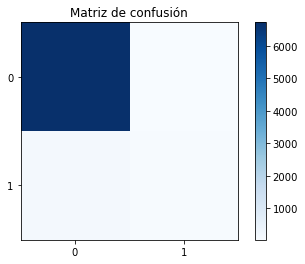

In [112]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, data['PudoPagar'].unique())
plt.yticks(tick_marks, data['PudoPagar'].unique())
plt.show()

In [136]:
print("Exactitud: ", metrics.accuracy_score(y_train, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_train, y_pred))
#print("Precisión     : ", metrics.precision_score(y_train, y_pred))
#print("Recall        : ", metrics.recall_score(y_train, y_pred))
VN = np.sum(cm[1:3,1:3])
print("VN: ", VN)
VP = np.sum(cm[0,0])
print("VP: ", VP)
FP = np.sum(cm[0,1:3])
print("FP: ", FP)
FN = np.sum(cm[1,0])
print("FN: ", FN)
specificity = VN/(VN+FP)
print("Especificidad : ", specificity)
print("Precisión: ", VP/VP+FP)
print("Recall: ", VP/VP+FN)

Exactitud:  0.9723851767062527
Kappa    :  0.3946536173978683
VN:  66
VP:  6730
FP:  27
FN:  166
Especificidad :  0.7096774193548387
Precisión:  28.0
Recall:  167.0


# 6. Comparación y conclusiones

El **mejor modelo Naive Bayes** fue el global con un kappa promedio del **40%** respecto de un **val_Smoothing** de **0.001**. Mientras que para los modelos de **knn fue equivalente** usar el general o los específicos, por lo cual se escoge el **general** con un parametro **k vecinos** de **9** con un kappa promedio de **45%**. Por ello se compararán estos dos por su **kappa ó indice de concordancia**

In [43]:
#HoldOut Inicial del data frame, 30% Test
x = pd.DataFrame({"Estudiante":data.Estudiante, "Deuda":data.Deuda, "Cuenta":data.Cuenta})
X_train, X_test, y_train, y_test = train_test_split(x, data["PudoPagar"], test_size=0.3, random_state=12345, stratify=data["PudoPagar"])

In [52]:
knn = neighbors.KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
kp = metrics.cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)
kp

0.4328605824449757

In [53]:
#Hold-Out sin variable binaria para el naive Bayes
x = pd.DataFrame({"Deuda":data.Deuda, "Cuenta":data.Cuenta})
X_train, X_test, y_train, y_test = train_test_split(x, data["PudoPagar"], test_size=0.3, random_state=12345, stratify=data["PudoPagar"])

In [64]:
naiveBayes = GaussianNB(var_smoothing = 0.001)
naiveBayes.fit(X_train, y_train)
y_pred = naiveBayes.predict(X_test)
kp = metrics.cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)
kp

0.33632821060053164

### Conclución
Desde el inicio de esta sesión, se conocía que el **KNN** con **k=9** vecinos era el modelo que respecto de su índice de concordancia era mejor para predecir el pago o no pago de un credito en estudiantes o no estudiantes, debido a que **todo el tiempo trabaje con el _kappa_**, esto lo hice, porque este es un indicador mas diciente que el **accuracy** por ejemplo, dado que me puede sesgar las predicciónes incluyendo los **Verdaderos Positivos y Verdaderos Negativos** que desde el **baseline** sepudieron conseguir **(La chiripa)**.
Sinembargo, decidí hacer de nuevo los modelos, **sin 5 Fold cross validation** para mostrar que incluso así la diferencia entre ambos modelos es notoria.